In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
import nltk
from sklearn.feature_extraction import DictVectorizer

CPU = torch.device('cpu')
GPU = torch.device('cuda')

In [2]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    if isinstance(data, dict):
        return dict((k, to_device(v, device)) for k, v in data.items())
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [3]:
anime_initial = pd.read_csv('./anime.csv')
ratings_initial = pd.read_csv('./rating.csv')

In [4]:
anime_initial = anime_initial.head(int(len(anime_initial) * 0.5))
ratings_initial = ratings_initial.head(int(len(ratings_initial) * 0.1))

# Предварительная обработка данных

In [5]:
anime_ids = set(ratings_initial['anime_id'].values)
anime_to_remove = [i for i, a_id in enumerate(anime_initial['anime_id']) if a_id not in anime_ids]

anime_ids = set(anime_initial['anime_id'].values)
rating_to_remove = [i for i, a_id in enumerate(ratings_initial['anime_id']) if a_id not in anime_ids]

ratings = ratings_initial.copy().drop(rating_to_remove).reset_index(drop=True)
anime = anime_initial.copy().drop(anime_to_remove).reset_index(drop=True)
new_ids = dict((v, k) for k, v in dict([*enumerate(anime['anime_id'])]).items())
ratings['anime_id'] = ratings['anime_id'].apply(new_ids.get)
anime['anime_id'] = anime['anime_id'].apply(new_ids.get)

Создадим матрицу, в которой юзеры будут строками, а тайтлы - столбцами. На их пересечении будет соответственно оценка.

In [6]:
USERS_NUM = ratings['user_id'].values.max()
ANIME_NUM = len(anime)
X = np.zeros((USERS_NUM, ANIME_NUM), np.int8)

for r in ratings.values:
    X[r[0]-1][r[1]] = r[2]

# Задание 1

### Распределение числа пользователей по количеству взаимодействий

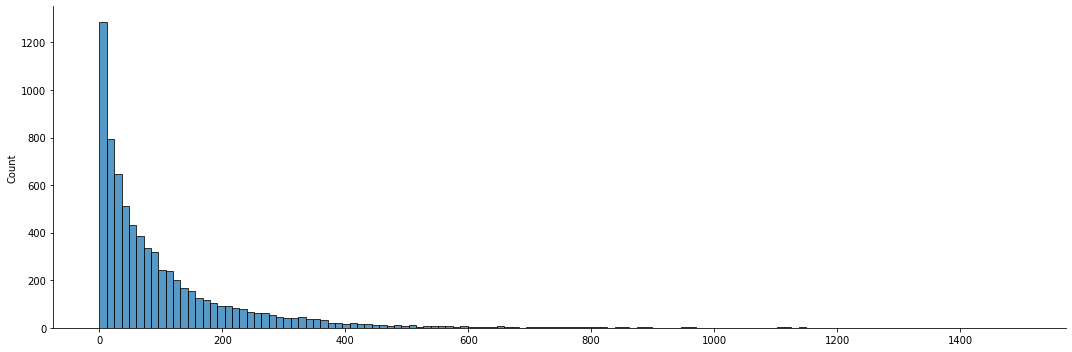

In [7]:
interactions = np.zeros(USERS_NUM)
for i, x in enumerate(X):
    interactions[i] += np.count_nonzero(x)

sns.displot(data=interactions, aspect=3)

### Разпределение числа "айтемов" по количеству взаимодействий

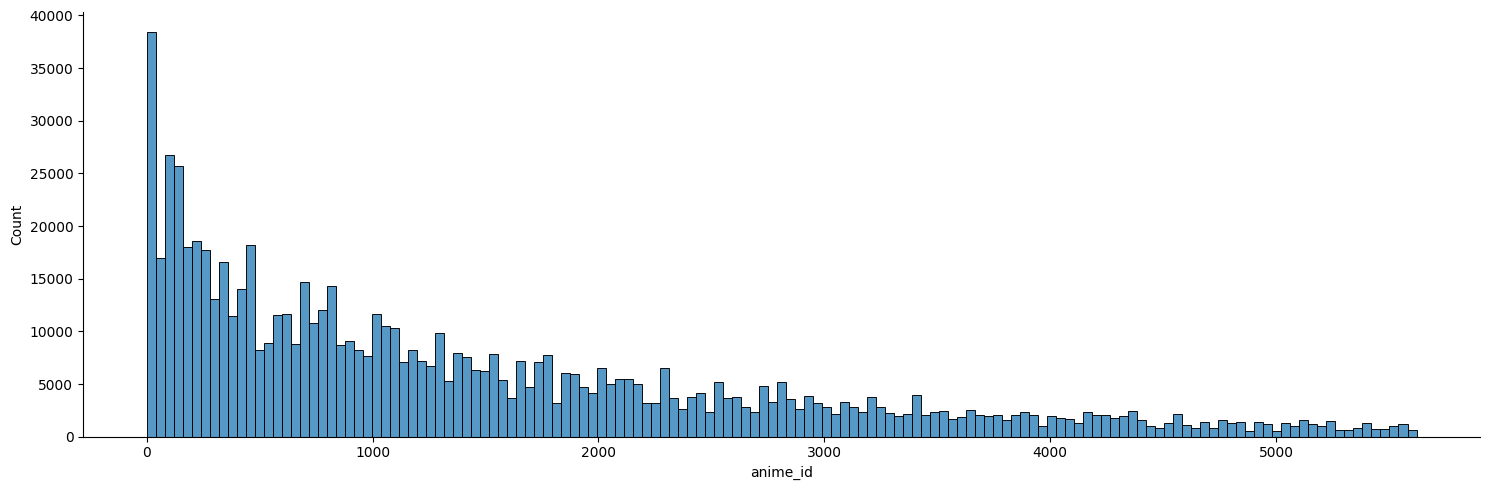

In [8]:
sns.displot(x='anime_id', data=ratings, aspect=3)

### Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"

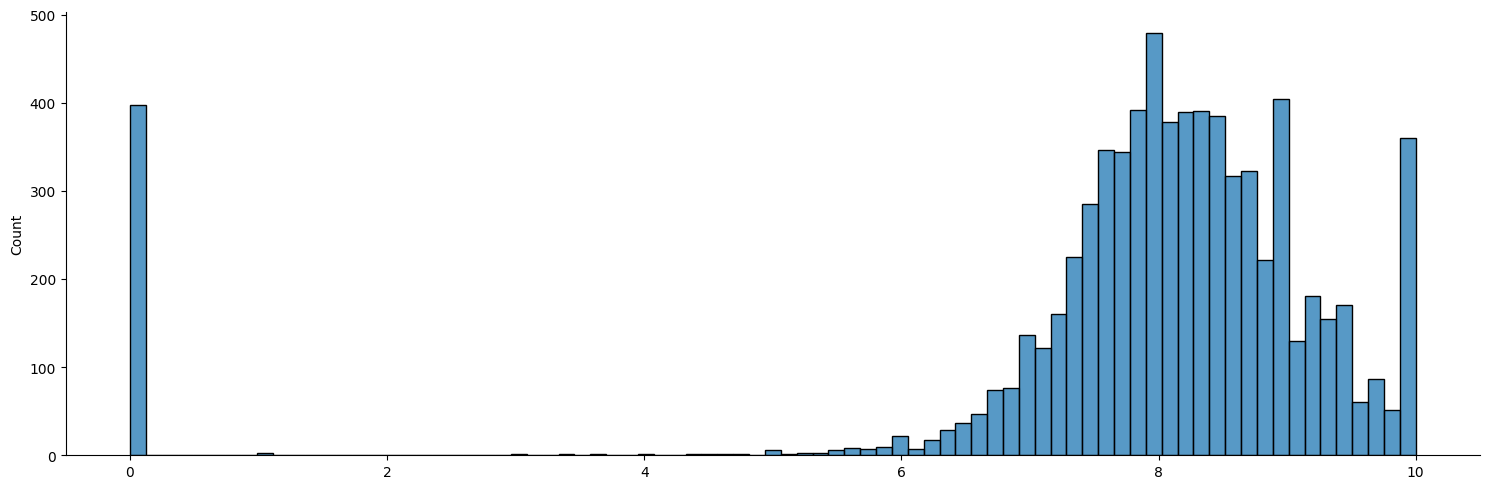

In [9]:
avg_rating = np.zeros(USERS_NUM)
for i, x in enumerate(X):
    val = x[x>0]
    if (len(val) != 0):
        avg_rating[i] = np.mean(val)

sns.displot(avg_rating, aspect=3)

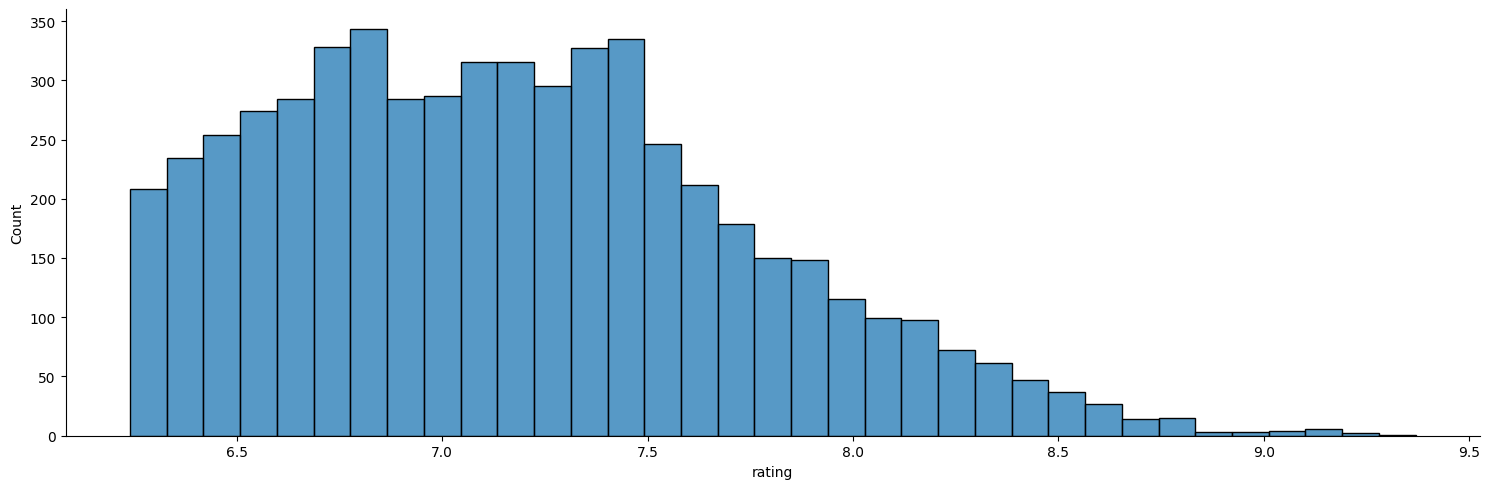

In [10]:
sns.displot(x='rating', data=anime, aspect=3)

# Задание 2

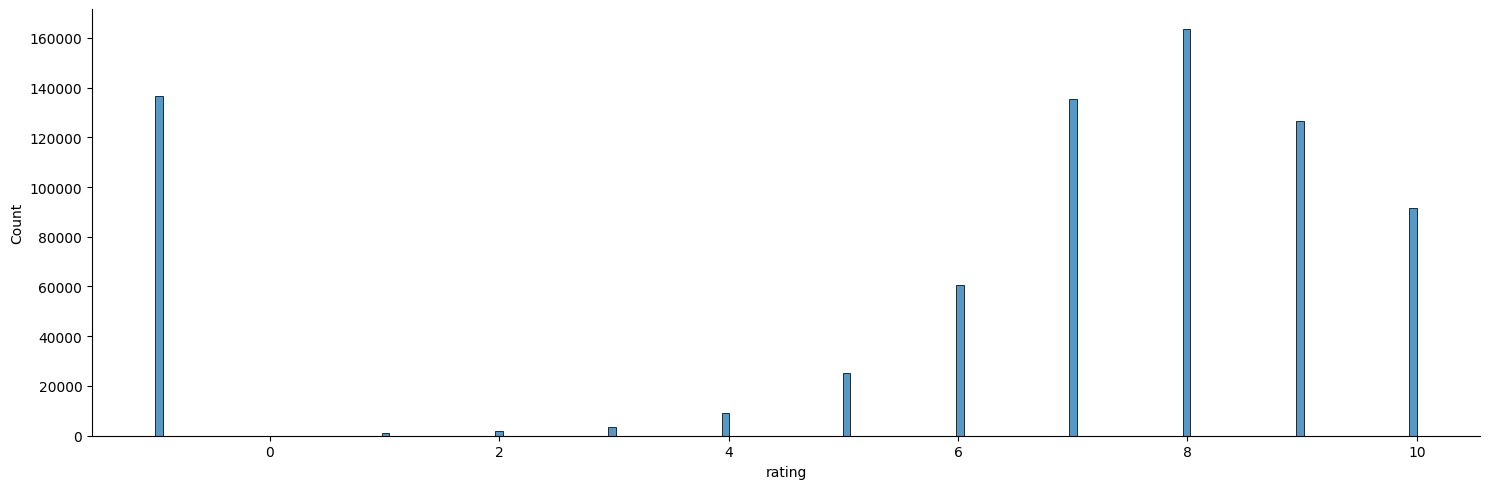

In [11]:
sns.displot(x='rating', data=ratings, aspect=3)

# Задание 4

In [12]:
def solve_most_popular1(user_id: int, result_size: int = 5):
    df = anime[['anime_id', 'rating', 'members']].copy()
    df.sort_values(by=['rating', 'members'], ascending=[False, False])
    return df.head(result_size)['anime_id'].values

In [13]:
def solve_most_popular2(user_id: int, result_size: int = 5):
    return ratings.groupby('anime_id', as_index=False).mean().sort_values(by='rating', ascending=False).head(result_size)['anime_id'].values

In [14]:
print(solve_most_popular1(131))
print(solve_most_popular2(123))

[0 1 2 3 4]
[3527 2921 4467 3008 4536]


# Задание 3 + Задание 5

In [15]:
U, D, V = np.linalg.svd(X, full_matrices=False)
k = 10
U = U[:, :k].astype(np.float32)
D = np.diag(D)[:k, :k].astype(np.float32)
V = V[:k, :].astype(np.float32)

In [16]:
def solve_collaborative_filter(user_id: int, result_size: int = 5):
    usr_factor = U[user_id]
    result = {i: usr_factor.dot(f) for i, f in enumerate(V.T)}
    return [k for k, _ in sorted(result.items(), key=lambda item: item[1], reverse=True)][:result_size]

In [17]:
print(solve_collaborative_filter(612))
print(solve_collaborative_filter(4211))
print(solve_collaborative_filter(241))

[19, 13, 39, 738, 1664]
[3, 10, 82, 154, 217]
[39, 82, 432, 782, 738]


# Задание 6

In [18]:
def encode(s: str, pad_size: int, word_to_num: dict[str, int], pad_sym, unk_sym):
    encoded = [word_to_num.get(tok, unk_sym) for tok in str.split(s, ' ')]

    if len(encoded) >= pad_size:
        return encoded[:pad_size]
    encoded.extend([pad_sym] * (pad_size - len(encoded)))
    return encoded

In [19]:
class AnimeDataset(Dataset):
    MIN_COUNT = 10
    PAD, UNK = 'PAD', 'UNK'
    PAD_IX, UNK_IX = 0, 1
    TEXT_COLS = ['name', 'genre']
    CATEGORIAL_COLS = ['type']
    NUMERIC_COLS = ['episodes', 'rating', 'members']
    TEXT_MAX_SIZE = 20 

    def _process_anime(self):
        self._anime[self.CATEGORIAL_COLS] = self._anime[self.CATEGORIAL_COLS].fillna('NaN')
        self._anime[self.TEXT_COLS] = self._anime[self.TEXT_COLS].fillna('NaN')
        self._anime[self.NUMERIC_COLS] = self._anime[self.NUMERIC_COLS].fillna(0)
        self._anime[self.NUMERIC_COLS] = self._anime[self.NUMERIC_COLS].replace('Unknown', 0)
        self._anime[self.NUMERIC_COLS] = MinMaxScaler().fit_transform(self._anime[self.NUMERIC_COLS])
        tokenizer = nltk.tokenize.WordPunctTokenizer()
        self._anime[self.TEXT_COLS] = self._anime[self.TEXT_COLS].applymap(lambda x: ' '.join(tokenizer.tokenize(x.lower())))
        tok_cntr = Counter()
        
        for col in self._anime[self.TEXT_COLS]:
            for line in self._anime[col].values:
                tok_cntr.update(line.split(' '))

        self._tokens = sorted(t for t, c in tok_cntr.items() if c >= self.MIN_COUNT)
        self._tokens = [self.PAD, self.UNK] + self._tokens
        self._token_to_id = {t: i for i, t in enumerate(self._tokens)}
        cat_vectorizer = DictVectorizer(dtype=np.float32, sparse=False).fit(self._anime[self.CATEGORIAL_COLS].apply(dict, axis=1))
        self._categorical = cat_vectorizer.transform(self._anime[self.CATEGORIAL_COLS].apply(dict, axis=1))
        self._numerical = np.zeros((ANIME_NUM, len(self.NUMERIC_COLS)))
        num = self._anime[self.NUMERIC_COLS].values
        
        for i in range(len(num)):
            self._numerical[self._anime.iloc[i]['anime_id']] = num[i]

    def __init__(self, U, V, anime: pd.DataFrame, ratings: pd.DataFrame):
        self._anime = anime
        self._ratings = ratings
        self._U = U
        self._V = V.T
        self._process_anime()

    def __getitem__(self, i):
        user_id = self._ratings.values[i][0] - 1
        anime_id = self._ratings.values[i][1]
        target = self._ratings.values[i][2]

        row = self._anime.values[anime_id]

        return (
            [
                torch.tensor(self._U[user_id], dtype=torch.float32),
                torch.tensor(self._V[anime_id], dtype=torch.float32),
                torch.tensor(encode(row[1], self.TEXT_MAX_SIZE, self._token_to_id, self.PAD_IX, self.UNK_IX), dtype=torch.int32),
                torch.tensor(encode(row[2], self.TEXT_MAX_SIZE, self._token_to_id, self.PAD_IX, self.UNK_IX), dtype=torch.int32),
                torch.tensor(self._categorical[anime_id], dtype=torch.float32),
                torch.tensor(self._numerical[anime_id], dtype=torch.float32)
            ],
            [
                torch.tensor([target], dtype=torch.float32)
            ]
        )
        
    def __len__(self):
        return len(self._ratings)

In [20]:
dataset = AnimeDataset(U, V, anime.copy(), ratings.copy())
train_size = round(len(dataset) * 0.70) 
val_size = round((len(dataset) - train_size) * (1/3))
test_size = (len(dataset) - train_size) - val_size 
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class NeuralNetwork(nn.Module):
    
    def __init__(self, emb_size=16, voc_size=len(dataset._tokens), k=10, linear_size=32):
        super().__init__()
        self.k = k
        self.emb_size = emb_size
        self.voc_size = voc_size
        self.linear_size = linear_size
        
        self.U_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.V_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.U_V_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.Embedder = nn.Embedding(voc_size, emb_size)
        
        self.N_encoder = nn.Sequential(
            nn.LazyConv1d(linear_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=linear_size // 2),
            nn.Flatten(start_dim=1),
        )
        
        self.G_encoder = nn.Sequential(
            nn.LazyConv1d(linear_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=linear_size // 2),
            nn.Flatten(start_dim=1),
        )
        
        self.C_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.N2_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.Filter = nn.Sequential(
            nn.LazyLinear(linear_size * 8),
            nn.ReLU(),
            nn.LazyLinear(linear_size * 4),
            nn.ReLU(),
            nn.LazyLinear(1)
        )
        
    def forward(self, batch):
        U = batch[0]
        V = batch[1]
        N = batch[2]
        G = batch[3]
        C = batch[4]
        N2 = batch[5]

        U_features = self.U_linear(U)
        V_features = self.V_linear(V)
        UV_features = torch.cat([U_features, V_features], dim=1)
        UV_features = self.U_V_linear(UV_features)
        
        N_emb = self.Embedder(N).permute(0, 2, 1)
        G_emb = self.Embedder(G).permute(0, 2, 1)
        
        N_features = self.N_encoder(N_emb)
        G_features = self.G_encoder(G_emb)
        
        C_features = self.C_linear(C)
        N2_features = self.N2_linear(N2)
        
        features = torch.cat(
            [UV_features,
            N_features,
            G_features,
            C_features,
            N2_features,], dim=1
        )
        
        prediction = self.Filter(features)
        
        return prediction

In [22]:
def evaluate(model, device=None):
    squared_error = abs_error = num_samples = 0.0

    loader = val_loader if not device else DeviceDataLoader(val_loader, device)

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            squared_error += torch.mean(torch.square(pred - y[0]))
            abs_error += torch.mean(torch.abs(pred - y[0]))
            num_samples += len(x)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples

    return mse, mae

In [23]:
def train(model, optimizer, epoches=5, device=None, criterion=nn.MSELoss(reduction='mean')):
    loader = train_loader

    if device:
        model.to(device)
        loader = DeviceDataLoader(train_loader, device)

    for epoch in range(epoches):
        model.train()
        for x, y in tqdm(loader):
            optimizer.zero_grad(set_to_none=True)
            pred = model(x)
            loss = criterion(pred, y[0])
            loss.backward()
            optimizer.step()

        mse, mae = evaluate(model, device)

    if device:
        model.cpu()

In [24]:
def test(model, device=None):
    squared_error = abs_error = num_samples = 0.0
    loader = test_loader

    if device:
        model.to(device)
        loader = DeviceDataLoader(test_loader, device)

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            squared_error += torch.mean(torch.square(pred - y[0]))
            abs_error += torch.mean(torch.abs(pred - y[0]))
            num_samples += len(x)

    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples

    if device:
        model.cpu()

    return mse, mae

In [25]:
model = NeuralNetwork()
train(model, torch.optim.Adam(model.parameters(), lr=1e-2), epoches=5)

C:\Python310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4129/4129 [11:15<00:00,  6.11it/s]


# Задание 7

In [26]:
from sklearn.metrics import ndcg_score


scores = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        pred = model(x)
        scores.append(ndcg_score([y[0].flatten().numpy()], [pred.flatten().numpy()]))

print(f'NDCG (content-based): {np.mean(scores)}')

NDCG (content-based): 0.9632554273132385


In [27]:
scores = []
usr = 1497

res = solve_collaborative_filter(usr, result_size=10)
true = np.flip(np.argsort(X[usr]))[:10] # pick 10 most liked animes

print(f'NDCG (collaborative filter): {ndcg_score([true], [res])}')

NDCG (collaborative filter): 0.8180916921106894
